## Lab Assignment Four: Multi-Layer Perceptron

#### Luis Garduno

Dataset : https://www.kaggle.com/muonneutrino/us-census-demographic-data/data


--------------------------------

## 1. Load, Split, & Balance

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.1 Loading Data & Adjustments  (5 points)

In [41]:
import numpy as np
import pandas as pd

# Load the data into memory & save it to a pandas data frame.
df = pd.read_csv("https://raw.githubusercontent.com/luisegarduno/MachineLearning_Projects/master/Datasets/acs2017_census_tract_data.csv");

# Zip State Name with ID number 
def_state = zip(df['State'].unique(), np.arange(52))

# Remove any observations having missing data.
df = df.dropna(axis=0, how='any')
del df['County']

# Encode State's as integers
df['State'] = pd.factorize(df.State)[0]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72718 entries, 0 to 74000
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           72718 non-null  int64  
 1   State             72718 non-null  int64  
 2   TotalPop          72718 non-null  int64  
 3   Men               72718 non-null  int64  
 4   Women             72718 non-null  int64  
 5   Hispanic          72718 non-null  float64
 6   White             72718 non-null  float64
 7   Black             72718 non-null  float64
 8   Native            72718 non-null  float64
 9   Asian             72718 non-null  float64
 10  Pacific           72718 non-null  float64
 11  VotingAgeCitizen  72718 non-null  int64  
 12  Income            72718 non-null  float64
 13  IncomeErr         72718 non-null  float64
 14  IncomePerCap      72718 non-null  float64
 15  IncomePerCapErr   72718 non-null  float64
 16  Poverty           72718 non-null  float6



### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.2 Splitting the Dataset (10 points)

In [42]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline
scaler = StandardScaler()

# 0.0 - 0.17 : 'Okay' | 0.17 - 0.28 : 'U.S. Poverty Rate' | 0.28 - 0.65 : 'Very Poor' | 0.65 - 1.00 : 'Extremely Poor'
df['ChildPoverty_Class'] = pd.qcut(df['ChildPoverty'],[0.0,0.17,0.28,0.65,1.0],labels=False) # this creates a new variable
#df['ChildPoverty'].quantile()

#df['ChildPoverty'].plot(kind='hist',alpha=1.0)   # Blue
#plt.show()

# Create X data & y target dataframe's
if 'ChildPoverty' in df:
    y = df['ChildPoverty'].values
    del df['ChildPoverty']
    X = df.to_numpy()


#X = scaler.fit_transform(X)

# Divide the data: 80% Training & 20% Testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print("Training Set", "\n   - Data Shape:",X_train.shape,"\n   - Target Shape:",y_train.shape)
print("\nTesting Set","\n   - Data Shape:",X_test.shape ,"\n   - Target Shape:",y_test.shape)

#df['ChildPoverty_Class'].plot(kind='hist',alpha=1.0)   # Blue
#plt.show()



# Assume I'm equally interested in the classification performance for each class in the dataset.
# Split the dataset into 80% for training and 20% for testing.

# Option 1.
# Figure out how I want to Quantize it  --> Quantize it --> Split it into 80/20

# Option 2.
# If introducing variables (Overlap Sampling) --> Split into 80/20 --> Introduce variables ONLY in dataset


Training Set 
   - Data Shape: (58174, 36) 
   - Target Shape: (58174,)

Testing Set 
   - Data Shape: (14544, 36) 
   - Target Shape: (14544,)


In [43]:
from sklearn import utils
from sklearn import metrics, svm
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA as RandomizedPCA

lab_enc = preprocessing.LabelEncoder()
training_scores_encoded = lab_enc.fit_transform(y_train)
print(training_scores_encoded)
print(utils.multiclass.type_of_target(y_train))
print(utils.multiclass.type_of_target(y_train.astype('int')))
print(utils.multiclass.type_of_target(training_scores_encoded))

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=35,random_state=0)),
                    ('clf', LogisticRegression(class_weight='balanced', random_state=0, max_iter=100))])

pipe_lr.fit(X_train, training_scores_encoded)
y_pred = pipe_lr.predict(X_test)
# print(classification_report(y_test, y_pred, target_names=training_scores_encoded))

def plot_filled(train_scores,test_scores,train_x_axis, xlabel=''):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_x_axis, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_x_axis,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_x_axis, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_x_axis,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
%matplotlib inline
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, n_jobs=-1)

[ 29  48 211 ... 480 200 309]
continuous
multiclass
multiclass


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


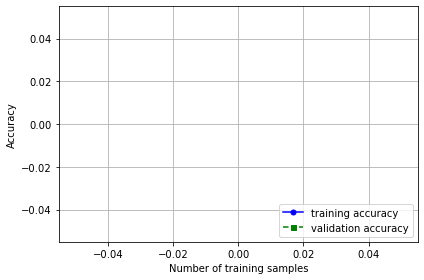

In [44]:
plot_filled(train_scores, test_scores, train_sizes, xlabel='Number of training samples')

The following resources were used to gain an understanding of where the national poverty was during 2017.

- <a href="https://www.childrensdefense.org/wp-content/uploads/2018/09/Child-Poverty-in-America-2017-State-Fact-Sheet.pdf" target="_top">
    <b>Child Poverty in America 2017: State Analysis</b>
  </a>
- <a href="https://www.childrensdefense.org/wp-content/uploads/2018/09/Child-Poverty-in-America-2017-National-Fact-Sheet.pdf" target="_top">
    <b>Child Poverty in America 2017: National Analysis</b>
  </a>

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.3 Balancing the Data(15 points)

In [45]:

# Balance the dataset so that about the same # of instances are within each class (divide into 4 classes by Child Poverty)
# Once I divide this up by child poverty(4 classes), each class has about the same # of examples for each of those counties

# Split 80/20. Balance 80, argue whether 20 should be balanced

# Choose a method for balancing the dataset (Quantiles or Overlap Sampling(Only do it on the training set))
# An option is to choose quantization thresholds for the "ChildPoverty" variable that equally divide the data into 4 classes.




- Explain reasoning for selecting this method for balancing the dataset. 


- Should balancing of the dataset be done for both the training & testing set? Explain.

If you do it to the test set, you're misrepresenting the reality of the dataset.
We do it on the training set so that our model doesn't overly classify just one child poverty rate.
But on the testing set we don't want to introduce new data or massage the data on a test set.
For the integrity of the data.


------------------------

## 2. Pre-Processing

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.1 Quantifying Performance (20 points)

In [46]:

# Use the example (try and use Glorant and mini-batching) two-layer perceptron network from the class example & quantify performance using accuracy.
# Don't normalize or one-hot encode the data (not yet).


In [47]:

# Be sure that training converges by graphing the loss function vs. # of epochs.



### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2 Normalizing Data (25 points)

In [48]:

# Now normalize the continuous numeric feature data.
# Use the example two-layer perceptron network from the class example & quantify performance using accuracy.


In [49]:

# Be sure that training converges by graphing the loss function vs. # of epochs.



### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.3 Normalizing & One Hot Encoding the Data (30 points)

In [50]:

# Now normalize the continuous numeric feature data AND one hot encode the categorical data.
# Use the example two-layer perceptron network from the class example & quantify performance using accuracy.


In [51]:

# Be sure that training converges by graphing the loss function vs. # of epochs.



### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.4 Comparing the Models (40 points)


In [52]:

# Compare the performance of the three models I just trained.


- Are there any meaningful differences in performance?
- In my own words,explain why these models have (or don't have) different performances.
    - _Use one-hot encoding & normalization on the dataset for the remainder of this lab assignment._


------------------

## 3. Modeling

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.1 Three-layer Support (50 points)


In [53]:

# Add sup for a third layer in the multi-layer perceptron.
# Add sup for saving(& plotting after training is completed) the avg magnitude of the gradient for each layer, for each epoch.


In [54]:

# Quantify the performance of the model & graph the magnitudes for each layer Vs. the # of epochs.



### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.2 Four-layer Support (60 points)

In [55]:

# Repeat the previous step, adding support for a fourth layer.



### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3 Five-layer Support (70 points)

In [56]:

# Repeat the previous step, adding support for a fifth layer.



### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.4 Adaptive Learning Technique w/ five-layer network (90 points)

In [57]:

# Implement an adaptive learning technique that was discussed in lecture & use it on the five layer network.
# Don't use AdaM for the adaptive learning technique. 



- Compare the performance of this model w/ & w/o the adaptive learning strategy.



---------------------------

## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4. Adaptive Momentum (100 points)
- 5000 level student: I have free reign to provide additional analyses.
- One idea: Implement adaptive momentum (AdaM) in the five layer neural network & quantify the performance. 


-----------------------

### Reference

Kaggle. US Census Demographics. https://www.kaggle.com/muonneutrino/us-census-demographic-data/data (Accessed 10-24-2020)